<a href="https://colab.research.google.com/github/sahlahadesina/Cancer_detection/blob/main/CNN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
import pandas as pd
import os
import cv2
import copy
from torchvision import models
import torch
import random
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score , confusion_matrix
from PIL import Image
import seaborn as sns



In [2]:
#seed everything to allow for reporidction of random values
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


setting everything to seed 42


In [3]:

full_train_df = pd.read_csv('/content/drive/MyDrive/AI_project/annotations_real.csv')

#path to dataset
train_path = '/content/drive/MyDrive/AI_project/train'
test_path = '/content/drive/MyDrive/AI_project/test'

SAMPLE_SIZE = 600

In [4]:
#full_train_df.head()
train_df = full_train_df[full_train_df['Partition'] == 'train']
train_df = train_df.iloc[:, :2]
train_df

,Image Name,Majority Vote Label
0,MHIST_aaa.png,0
1,MHIST_aab.png,1
2,MHIST_aac.png,0
3,MHIST_aae.png,1
4,MHIST_aaf.png,0
...,...,...
3145,MHIST_bub.png,0
3146,MHIST_bvy.png,0
3147,MHIST_cpn.png,0
3150,MHIST_dlf.png,0


In [5]:
#print(train_df['Majority Vote Label'].value_counts())


#**Sampling, Concatenation and Shuffling**
Shuffling Data Set to Prevent the model from having Bias towards any class.

In [6]:


# The random_state=42 parameter ensures reproducibility of the sampling process.
df_negatives = train_df[train_df['Majority Vote Label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = train_df[train_df['Majority Vote Label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
#The positive and negative samples obtained above are concatenated along the rows using pd.concat() with axis=0 (vertical concatenation).
#reset_index(drop=True) resets the index of the concatenated DataFrame and drops the old index.
#sklearn.utils.shuffle() shuffles the rows of the concatenated DataFrame to ensure randomness.

train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))
print(train_df['Majority Vote Label'].value_counts())


Majority Vote Label
0    600
1    600
Name: count, dtype: int64


In [7]:
# # Our own custom class for datasets
# class CreateDataset(Dataset):
#     def __init__(self, df_data, data_dir = './', transform=None):
#         super().__init__()
#         self.df = df_data.values
#         self.data_dir = data_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         #img_name = self.df['Image Name'].iloc[index]
#         #label = self.df['Majority Vote Label'].iloc[index]
#         img_name,label = self.df[index]
#         #img_name = os.path.splitext(img_name)[0]
#         img_path = os.path.join(self.data_dir, img_name)

#         print("Image path:", img_path)

#         if not os.path.exists(img_path):
#           print(f"Image file not found: {img_path}")
#         return None, label

#         image = cv2.imread(img_path)
#         if image is None:
#           print(f"Failed to read image from path: {img_path}")
#           #return None, label

#         if self.transform is not None:
#             image = self.transform(image)

#         return image, label


class CreateDataset(Dataset):

    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
          img_name, label = self.df[index]
          img_path = os.path.join(self.data_dir, img_name)

          if not os.path.exists(img_path):
              print(f"Image file not found: {img_path}")

          else:
              image = cv2.imread(img_path)
              if image is None:
                  print(f"Failed to read image from path: {img_path}")

              else:
                  if self.transform is not None:
                      image = self.transform(image)
                      #print(f"Image loaded & transformed successfully: {index}")

                  return image, label







In [8]:

transforms_train = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((224, 224)),
              transforms.RandomHorizontalFlip(p=0.4),
              transforms.RandomVerticalFlip(p=0.4),
              transforms.RandomRotation(20),
              transforms.ToTensor(),
              # We the get the following mean and std for the channels of all the images
              #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])


train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

# Set Batch Size
batch_size = 64

# Percentage of training set to use as validation
valid_size = 0.1

print(train_data)
print(len(train_data))
#train_data.data_dir




1200


In [9]:
#this section dvided the training data into two more sections (validation data & training data)
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print(valid_idx)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [10]:
# Create Samplers
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

#alternatively
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)


# prepare data loaders (combine dataset and sampler)
# train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
# valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

# print(len(train_loader))
# for data, target in train_loader:
#     print(data.shape)
#     print(target.shape)
#     break

#great works!

In [11]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
test_df = full_train_df[full_train_df['Partition'] == 'test']
test_df = test_df.iloc[:, :2]

#sample_sub = pd.read_csv('/content/drive/MyDrive/AI_project/annotations.csv')
test_data = CreateDataset(df_data=test_df, data_dir=test_path, transform=transforms_test)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [12]:
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


#**Training the Resnet101 Model**

In [13]:
model = models.resnet101(pretrained=True)
num_features=model.fc.in_features
model.fc=nn.Linear(num_features,2)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Move model to GPU if available
if train_on_gpu: model.cuda()


In [15]:
!cat /proc/meminfo | grep MemFree

MemFree:         4234256 kB


In [16]:
print(type(train_loader))
print(train_loader)


<class 'torch.utils.data.dataloader.DataLoader'>


In [17]:
params_to_update = model.parameters()
params_to_update = []
for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print(name)


In [18]:
#optimizer = optim.SGD(params_to_update, lr=0.0025, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr=0.00015)
# Loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 4


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
#!mkdir /content/drive/MyDrive/AI_project/saved_weights

def train_model(model, train_dataloaders, val_dataloaders, optimizer, criterion=criterion, num_epochs=n_epochs, is_inception=False):
   # start = time.time()
    val_acc_history = []

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # Each epoch's training and validation phase

        #train phase
        model.train()
        #print("model trained successfully")
        running_loss = 0
        running_corrects = 0

        #print("traininig starting")
        for inputs, labels in train_dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #print("optimizer starting")
            optimizer.zero_grad()


            with torch.set_grad_enabled(True):
                    if is_inception:      # Special case of inception because InceptionV3 has auxillary outputs as well.
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    loss.backward()
                    optimizer.step()

                  # Stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)

        epoch_loss_train = running_loss / len(train_dataloaders.dataset)
        epoch_acc_train = running_corrects.double()/ len(train_dataloaders.dataset)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #print("evaluation starting")
#validation phase
        model.eval()
        running_loss = 0
        running_corrects = 0

        for inputs, labels in val_dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              _, preds = torch.max(outputs, 1)

              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds==labels.data)

        epoch_loss_vali = running_loss / len(train_dataloaders.dataset)
        epoch_acc_vali = running_corrects.double() / len(val_dataloaders.dataset)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_vali, epoch_acc_vali))


        # Deep copy the model
        if epoch_acc_vali > best_acc:
            best_acc = epoch_acc_vali
            best_model_weights = copy.deepcopy(model.state_dict())
            val_acc_history.append(epoch_acc_vali)
            torch.save(model.state_dict(),'/content/drive/MyDrive/AI_project/saved_weights/resenet7.pt')

    #time_elapsed = time.time() - start

    #print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

################################################################


In [30]:
model, history = train_model(model,train_loader,valid_loader, optimizer, criterion, n_epochs, False)

Epoch 0/3
----------
Train Loss: 0.4166 Acc: 0.8208
Val Loss: 0.3974 Acc: 0.8333
Epoch 1/3
----------
Train Loss: 0.4217 Acc: 0.8283
Val Loss: 0.4176 Acc: 0.8233
Epoch 2/3
----------
Train Loss: 0.3947 Acc: 0.8333
Val Loss: 0.4164 Acc: 0.8117
Epoch 3/3
----------
Train Loss: 0.3999 Acc: 0.8442
Val Loss: 0.3891 Acc: 0.8350
Best val Acc: 0.835000


In [31]:
model = models.resnet50(pretrained=False).to(device)
# model.fc = nn.Sequential(
#                nn.Linear(2048, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 2)).to(device)

num_features=model.fc.in_features
model.fc=nn.Linear(num_features,2)
if train_on_gpu: model.cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/AI_project/saved_weights/resenet5.pt'))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [32]:
#set model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
correct = 0
total = 0
true_labels = []
predicted_labels = []
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for images, labels in test_loader:  # assuming you have a DataLoader for your test set
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print('Accuracy of the network on the test images: {:.2f}%'.format(accuracy))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

Accuracy of the network on the test images: 70.52%


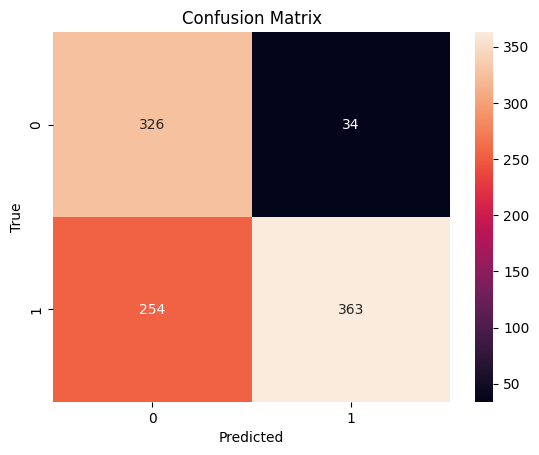

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(true_labels, predicted_labels)

#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt="d")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [35]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.91      0.69       360
           1       0.91      0.59      0.72       617

    accuracy                           0.71       977
   macro avg       0.74      0.75      0.70       977
weighted avg       0.78      0.71      0.71       977



In [36]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

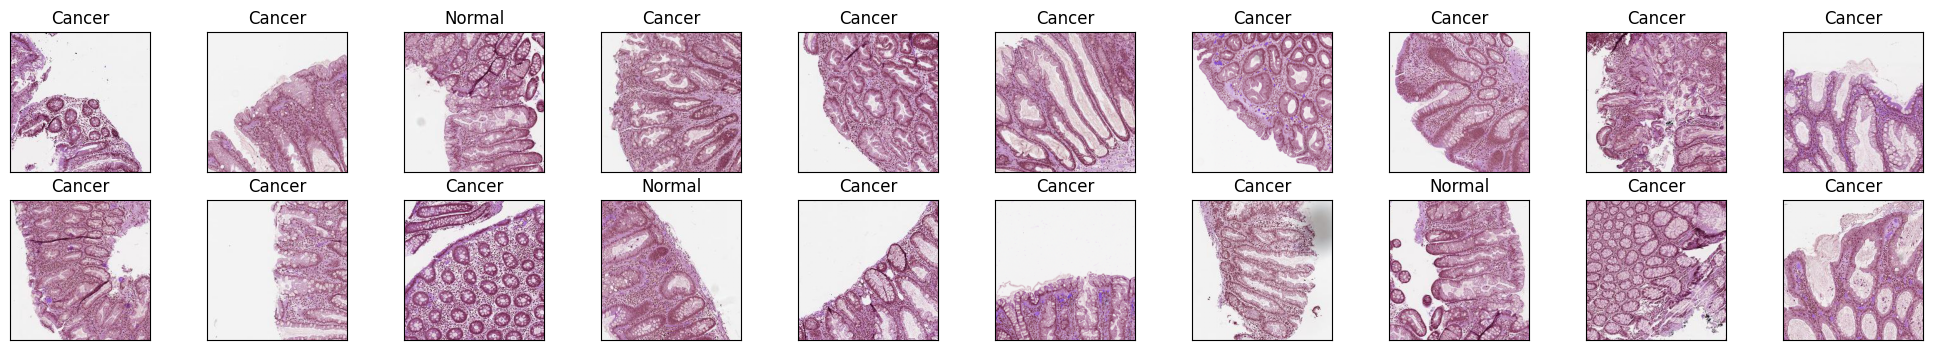

In [37]:
# Iterate over the test_loader to get a batch of data
for images, labels in test_loader:
    images = images.numpy()  # Convert images to numpy for display

    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))

    # Display 20 images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        prob = "Cancer" if labels[idx].item() >= 0.5 else "Normal" #1 is cancer, 0 is normal
        ax.set_title('{}'.format(prob))

    break  # Break after displaying one batch of data